# ONDELETTES

## Téléchargement des librairies

In [1]:
import pandas as pd
import numpy as np
import os
import pickle

# ACP
import sklearn.decomposition as sd
import sklearn.preprocessing as sp

# Hierarchical clustering
import scipy.cluster.hierarchy as sch
#Wavelet
import pywt
from pywt import wavedec
from statsmodels.robust import mad
# LOF
import sklearn.neighbors as sn
# Isolation Forest
import sklearn.ensemble as se
#One Class SVM
import sklearn.svm as ssvm

# Plot et Display
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sb
sb.set()
sb.set_style("darkgrid", {"axes.facecolor": ".9"})

# Interactive display
from ipywidgets import interact, widgets, interactive, fixed, interact_manual
from IPython.display import display

## Lecture des données

On lit directement les données nettoyées et dont la longueur a été modifiée à 1024.

In [41]:
import pickle
with open('X_1024', 'rb') as fichier:
    mon_depickler = pickle.Unpickler(fichier)
    X_1024, ind = mon_depickler.load() #X_1024 : données  #ind : liste des indices des signaux
n = len(X_1024) #nb de signaux
liste_appr = list(np.asarray(X_1024)[np.asarray(ind) <= 299])
liste_test = list(np.asarray(X_1024)[np.asarray(ind) > 299])

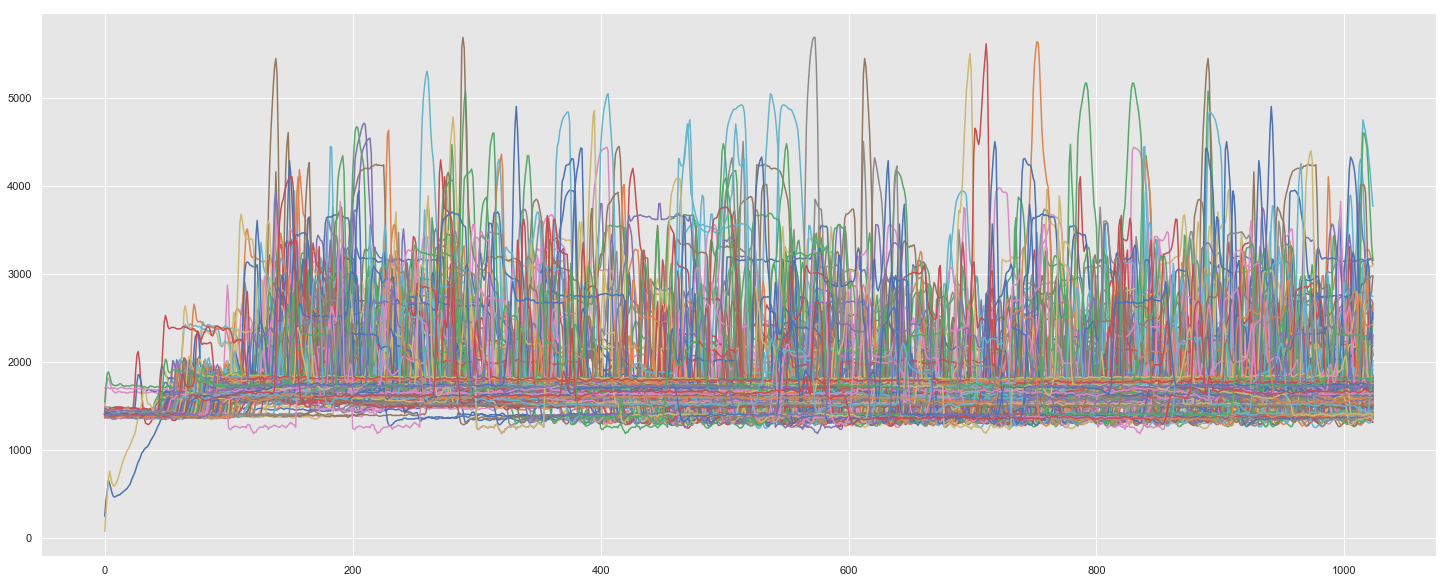

In [40]:
fig = plt.figure(figsize=(25, 10))
for x in X_1024:
    plt.plot(x)

## Décomposition en ondelettes

On effectue la décomposition en ondelettes pour chaque signal et on récupère 2 tableaux de coefficients, l'un avec tous les coefficients de chaque signal, l'autre avec les coefficients seuillés. On pourra réaliser la décomposition en ondelettes seuillés avec les modes `hard`, `soft`, `greater` ou `less`.

In [4]:
wf = 'haar'
wavelist=['haar','db2','db3','db4','coif1','coif2','coif3','sym2','sym3']

Coeff = []
TCoeff = []
for x in X_1024:
    #Apply wavelet decomposition
    coeffs = pywt.wavedec(x,wf,level=8) 
    coeffs_flatten = np.hstack(coeffs)
    Coeff.append(coeffs_flatten)
    # Compute universal Threshold http://jseabold.net/blog/2012/02/23/wavelet-regression-in-python/
    sigma = mad(coeffs[-1])
    uthresh = sigma*np.sqrt(2*np.log(1024))
    # Apply Threshold on 4 first levels
    coeffs_thresh = [pywt.threshold(c, uthresh, mode="hard") if j<=3 else c for j,c in enumerate(coeffs[::-1])]
    coeffs_thresh_flatten = np.hstack(coeffs_thresh[::-1])
    TCoeff.append(coeffs_thresh_flatten)
    
Coeff = np.array(Coeff)
TCoeff = np.array(TCoeff)
print(Coeff.shape, TCoeff.shape)
print(np.sum(Coeff!=0), np.sum(TCoeff!=0))

(425, 1024) (425, 1024)
304114 137127


**Q** : QUEL MODE DE SEUILLAGE ?

### Choix des coefficients

In [5]:
#Coefficient de niveau 7 à 10:
Coeff7=Coeff[:,128:]
#Coefficient de niveau 1 à 6 : 
CoeffA6=Coeff[:,:128]
#Coefficient de niveau 1 à 4 : 
CoeffA4=Coeff[:,:16]

In [6]:
#Liste et dictionnaire des coefficients #Utile pour les fonctions interactives
Coeff_liste=["Coeff","Coeff7","CoeffA6","CoeffA4","TCoeff"]
dict_coeff ={"Coeff" : Coeff,"Coeff7" : Coeff7, "CoeffA6" : CoeffA6, "CoeffA4" : CoeffA4, "TCoeff" : TCoeff}

## Analyse en composantes principales sur les coefficients d'ondelettes

### Fonctions d'affichage

In [7]:
def plot_var_ACP(X_acp, acp) :
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,2,1)
    ax.bar(range(10), acp.explained_variance_ratio_[:10]*100, align='center', color='grey', ecolor='black')
    ax.set_xticks(range(10))
    ax.set_ylabel("Variance")
    ax.set_title("Pourcentage de variance expliquée \n des premières composantes", fontsize=20)

    ax = fig.add_subplot(1,2,2)
    box = ax.boxplot(X_acp[:, 0:10])
    ax.set_title("Distribution des premières composantes", fontsize=20)
    plt.show()
    
def plot_proj_ACP(X_acp, axe_1=0, axe_2=1, etiq=True) :
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,1,1)
    dict_color = {True : "blue", False : "red"}

    for x, y, s in zip(X_acp[:,axe_1], X_acp[:,axe_2], ind) :
        ax.plot(x,y,marker=".", color=dict_color[s < 300]) #300 : longueur liste apprentissage
        if etiq :
            ax.text(x, y, str(s))
       
    ax.set_title("Projection des invididus sur les \n  deux premières composantes", fontsize=20)

    legend_elements = [Line2D([0], [0], marker='.', color='blue', label='Série du jeu d\'apprentissage', markersize=10, linewidth=0),
                       Line2D([0], [0], marker='.', color='red', label='Série du jeu de test', markersize=10, linewidth=0)]

    ax.legend(handles=legend_elements)

    plt.show()
    

#### ACP pour tous les coefficients (A GARDER POUR L'INSTANT)

Ondelettes, tous les coefficients :


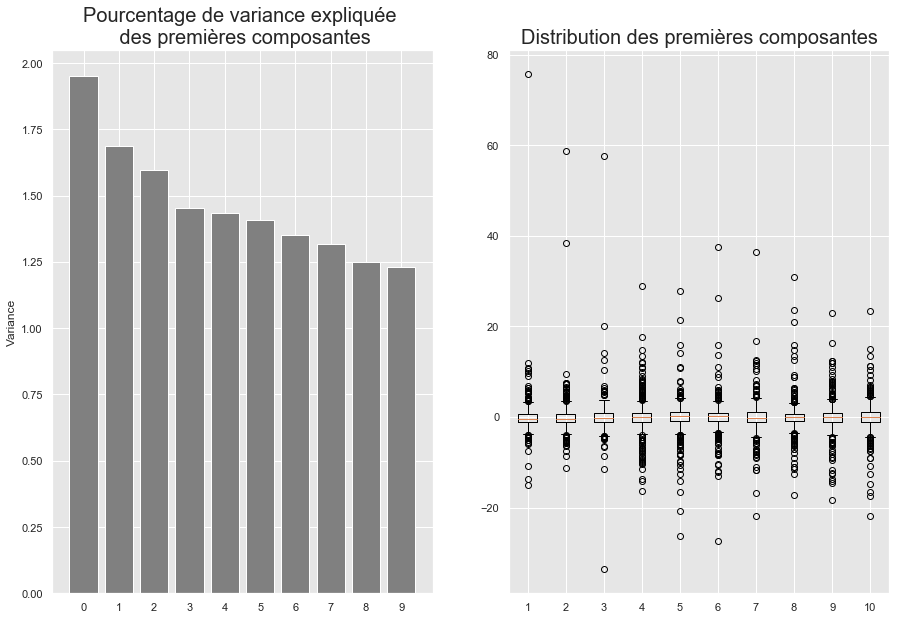

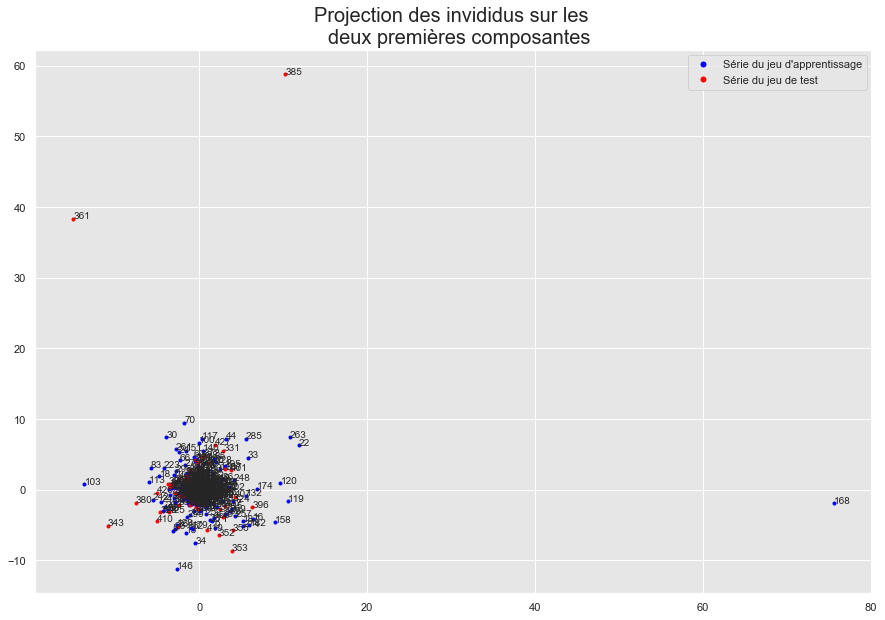

In [8]:
# Tous les coefficients d'ondelettes
acp_ond = sd.PCA()
X_acp_ond = acp_ond.fit_transform(sp.scale(Coeff))
print("Ondelettes, tous les coefficients :")
plot_var_ACP(X_acp_ond, acp_ond)
plot_proj_ACP(X_acp_ond)
plt.show()

### Visualisation des résultats

In [9]:
@interact(Choix_coeff=Coeff_liste)
def ACP(Choix_coeff):
    Coeff=dict_coeff[Choix_coeff]
    acp = sd.PCA()
    X_acp = acp.fit_transform(sp.scale(Coeff))
    plot_var_ACP(X_acp, acp)
    plot_proj_ACP(X_acp, axe_1=0, axe_2=1)

interactive(children=(Dropdown(description='Choix_coeff', options=('Coeff', 'Coeff7', 'CoeffA6', 'CoeffA4', 'T…

## Classification ascendante hierarchique

### Fonction d'affichage

In [10]:
def plot_dendrogram(Z,p):
    fig = plt.figure(figsize=(25, 10))
    sch.dendrogram(Z, p, leaf_rotation=45.,leaf_font_size=15, truncate_mode="level", labels=ind)  # font size for the x axis labels
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    plt.show()

#### Dendrogram sur tous les coeff (A GARDER POUR L'INSTANT)

Ondelettes, tous les coefficients :


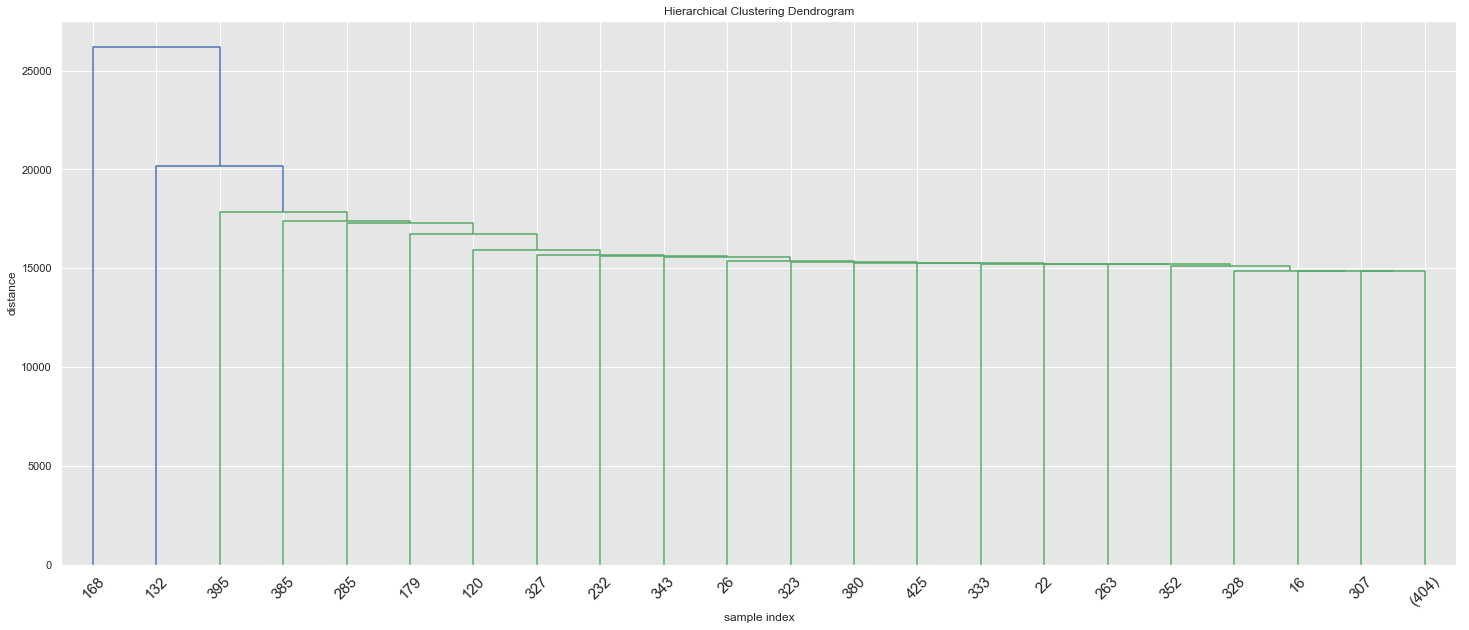

In [11]:
# Tous les coefficients d'ondelettes
Z_ond = sch.linkage(Coeff, 'single')
C = np.array([c[0] for c in sch.cut_tree(Z_ond,5)])
CT_ond = pd.DataFrame(list(C), columns=["HCA_cluster"])
p=20
print("Ondelettes, tous les coefficients :")
plot_dendrogram(Z_ond,p)
plt.show()

### Visualisation des résultats

In [12]:
@interact(Choix_coeff=Coeff_liste,p=widgets.IntSlider(min=1,max=50,step=1,value=20,continuous_update=False))
def CAH(Choix_coeff,p):
    Coeff=dict_coeff[Choix_coeff]
    Z = sch.linkage(Coeff, 'single')
    C = np.array([c[0] for c in sch.cut_tree(Z,5)])
    CT = pd.DataFrame(list(C), columns=["HCA_cluster"])
    plot_dendrogram(Z,p)
    

interactive(children=(Dropdown(description='Choix_coeff', options=('Coeff', 'Coeff7', 'CoeffA6', 'CoeffA4', 'T…

## Fonctions de visualistion des résultats pour IF, OC-SVM, LOF

In [13]:
def print_anomalies(ind_anomalies,ind_data = ind):
    return [ind_data[i] for i in ind_anomalies]

In [14]:
# A GARDER POUR L'INSTANT
def make_figure(fig, ax, CT, legend=False):
    y_lim = (-1.13,1.13)
    x_lim = [-5,n+5]
    CT_Normal = CT[CT.pred==1]
    CT_Anomaly = CT[CT.pred==-1]
    
    ax.scatter(CT_Normal.index, - CT_Normal.pred, color="green", label="Normal")
    ax.scatter(CT_Anomaly.index, - CT_Anomaly.pred, color="red", label="Anomaly detected")
    
    #for x,y,s in zip(CT_Anomaly.index, - CT_Anomaly.pred, map(str,CT_Anomaly.index)):
    #    ax.text(x,y,s, horizontalalignment="center", verticalalignment="center", color="red")

    ax.plot(x_lim, [0,0], color="black")
    ax.set_xlim(*x_lim)
    ax.set_ylim(y_lim)
    
    if legend:
        plt.legend(bbox_to_anchor=(1,1), fontsize=20)

**METHODE A ADAPTER**

In [15]:
#Methode : IF, OC-SVM, LOF
#contamination : IF, LOF
#nu : OC-SVM
#n_neighbors : LOF
def level(X_acp_ond,contamination,methode): 
    xx, yy = np.meshgrid(np.linspace(X_acp_ond[:,0].min()-5, X_acp_ond[:,0].max()+5, 500), 
                         np.linspace(X_acp_ond[:,1].min()-1, X_acp_ond[:,1].max()+1, 500))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.set_title(str(methode) + ", contamination = %f" + str(contamination))
    ax.contourf(xx, yy, Z, levels=[Z.min(), clf.threshold_, Z.max()], cmap = plt.cm.PuBu)

    s = 40
    b1 = plt.scatter(X_acp_ond[:,0], X_acp_ond[:,1], c='white', s=s, edgecolors='k')
    labels=[]
    for x,y,ss,  in zip(X_acp_ond[:,0], X_acp_ond[:,1], map(str,ind)):
        ax.scatter(x,y, c=COLOR_DIC[a],  s=s, edgecolors='k')
    plt.legend()

## Isolation Forest

#### IF sur tous les coefficients (A GARDER POUR L'INSTANT)

In [16]:
def IF(Coeff,contamination):
    clf = se.IsolationForest(n_estimators=100, contamination=contamination, bootstrap=True, n_jobs=-1)
    clf.fit(Coeff)
    y_pred = clf.predict(Coeff)
    return pd.DataFrame(list(y_pred), columns=["pred"])

C:\Users\paul-\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\paul-\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Text(0.5, 1.0, 'Ondelettes, tous les coefficients')

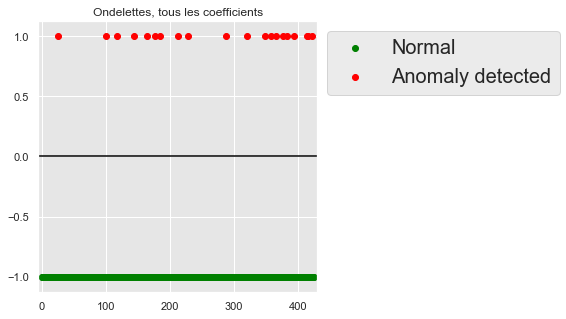

In [17]:
contamination=20/n
#Sur tous les coefficients d'ondelettes
CT_IF_ond = IF(Coeff,contamination)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
make_figure(fig,ax,CT_IF_ond,legend=True)
ax.set_title("Ondelettes, tous les coefficients")

### Visualisation des résultats

In [18]:
contamination=20/n
n_estimators=100

@interact(Choix_coeff=Coeff_liste)
def plot_IF_anomaly(Choix_coeff):
    Coeff=dict_coeff[Choix_coeff]
    
    clf = se.IsolationForest(n_estimators=n_estimators, contamination=contamination, bootstrap=True, n_jobs=-1)
    clf.fit(Coeff)
    pred = clf.predict(Coeff)
    
    acp_ond = sd.PCA()
    X_acp_ond = acp_ond.fit_transform(sp.scale(Coeff))
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,1,1)
    for i, j, nom, s in zip(X_acp_ond[:,0], X_acp_ond[:,1], pred, ind):
        color = "red" if nom!=1  else "grey"
        plt.plot(i, j, "o",color=color) 
        if nom!=1:
            ax.text(i,j,str(s))
    ax.set_title("Repésentation des atypiques sur la projection des 2 premières composantes de l'ACP", fontsize=20)
    plt.show()
    
    print("Anomalies : ", print_anomalies([i for i,x in enumerate(pred) if x!=1]))

interactive(children=(Dropdown(description='Choix_coeff', options=('Coeff', 'Coeff7', 'CoeffA6', 'CoeffA4', 'T…

## One Class SVM

#### OCSVM sur tous les coefficients (A GARDER POUR L'INSTANT)

In [34]:
def OCSVM(Coeff,nu):
    OCS = ssvm.OneClassSVM(kernel="rbf",nu=nu)
    OCS.fit(Coeff)
    pred = OCS.predict(Coeff)
    return pd.DataFrame(list(pred), columns=["pred"])

C:\Users\paul-\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Text(0.5, 1.0, 'Ondelettes, tous les coefficients')

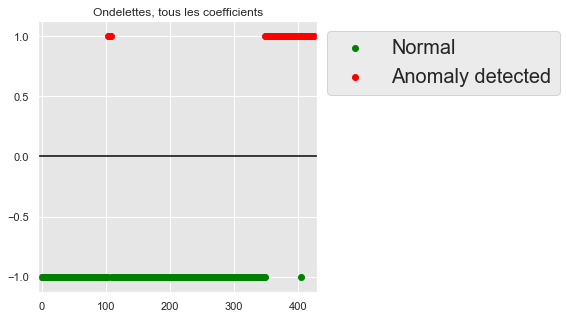

In [35]:
nu=1-20/n
#Sur tous les coefficients d'ondelettes
CT_OCSVM_ond = OCSVM(Coeff,nu)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
make_figure(fig,ax,CT_OCSVM_ond,legend=True)
ax.set_title("Ondelettes, tous les coefficients")

### Visualisation des résultats

**AFFINER LE CHOIX DE NU + verifier comment ça marche**

In [21]:
#nu=1-20/n
kernel="rbf"

@interact(Choix_coeff=Coeff_liste,nu=widgets.FloatSlider(min=0.1,max=1.0,step=0.01,value=0.5))
def plot_OCSVM_anomaly(Choix_coeff,nu):
    Coeff=dict_coeff[Choix_coeff]
    
    OCS = ssvm.OneClassSVM(kernel=kernel,nu=nu)
    OCS.fit(Coeff)
    pred = OCS.predict(Coeff)
    
    acp_ond = sd.PCA()
    X_acp_ond = acp_ond.fit_transform(sp.scale(Coeff))
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,1,1)
    for i, j, nom, s in zip(X_acp_ond[:,0], X_acp_ond[:,1], pred, ind):
        color = "red" if nom!=1  else "grey"
        plt.plot(i, j, "o",color=color) 
        if nom!=1:
            ax.text(i,j,str(s))
    ax.set_title("Repésentation des atypiques sur la projection des 2 premières composantes de l'ACP", fontsize=20)
    plt.show()
    
    print("Anomalies : ", print_anomalies([i for i,x in enumerate(pred) if x!=1]))

interactive(children=(Dropdown(description='Choix_coeff', options=('Coeff', 'Coeff7', 'CoeffA6', 'CoeffA4', 'T…

## Local Outlier Factor

#### LOF sur tous les coefficients (A GARDER POUR L'INSTANT)

In [22]:
def LOF(Coeff,n_neighbors,contamination,metric):
    clf = sn.LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, metric=metric)
    y_pred = clf.fit_predict(Coeff)
    return pd.DataFrame(list(y_pred), columns=["pred"])

Text(0.5, 1.0, 'Ondelettes, tous les coefficients')

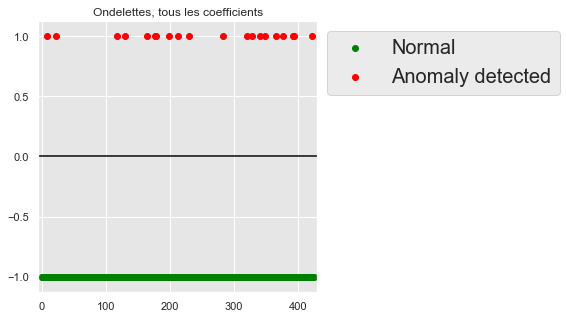

In [23]:
contamination=20/n
metric = "euclidean"
n_neighbors = 15
#Sur tous les coefficients d'ondelettes
CT_LOF_ond = LOF(Coeff,n_neighbors,contamination,metric)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
make_figure(fig,ax,CT_LOF_ond,legend=True)
ax.set_title("Ondelettes, tous les coefficients")

### Visualisation des résultats

In [24]:
contamination=20/n
metric = "euclidean"
#n_neighbors = 15

@interact(Choix_coeff=Coeff_liste,n_neighbors=widgets.IntSlider(min=1,max=30,step=1,value=15))
def plot_LOF_anomaly(Choix_coeff,n_neighbors):
    Coeff=dict_coeff[Choix_coeff]
    
    clf = sn.LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, metric=metric)
    pred = list(clf.fit_predict(Coeff))
    
    acp_ond = sd.PCA()
    X_acp_ond = acp_ond.fit_transform(sp.scale(Coeff))
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,1,1)
    for i, j, nom, s in zip(X_acp_ond[:,0], X_acp_ond[:,1], pred, ind):
        color = "red" if nom!=1  else "grey"
        plt.plot(i, j, "o",color=color) 
        if nom!=1:
            ax.text(i,j,str(s))
    ax.set_title("Repésentation des atypiques sur la projection des 2 premières composantes de l'ACP", fontsize=20)
    plt.show()
    
    print("Anomalies : ", print_anomalies([i for i,x in enumerate(pred) if x!=1]))

interactive(children=(Dropdown(description='Choix_coeff', options=('Coeff', 'Coeff7', 'CoeffA6', 'CoeffA4', 'T…

## Comparaison des méthodes IF, OC-SVM et LOF

In [25]:
methode_liste = ["Isolation Forest", "One-Class SVM", "Local Outlier Factor"]
contamination = 20/n #IF, LOF
n_neighbors = 15 #LOF
nu = 1-20/n #OC-SVM

#A CONSERVER : peut etre utile pour faire le choix des parametres
def f(**args):
    return args

@interact(Choix_coeff=Coeff_liste, methode=methode_liste)
def plot_anomaly(Choix_coeff, methode):
    Coeff=dict_coeff[Choix_coeff]
    
    if methode=="Local Outlier Factor":
        clf = sn.LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, metric="euclidean")
        pred = clf.fit_predict(Coeff)
    elif methode=="Isolation Forest":
        clf = se.IsolationForest(n_estimators=n_estimators, contamination=contamination, bootstrap=True, n_jobs=-1)
        clf.fit(Coeff)
        pred = clf.predict(Coeff)
    elif methode=="One-Class SVM":
        OCS = ssvm.OneClassSVM(kernel=kernel,nu=nu)
        OCS.fit(Coeff)
        pred = OCS.predict(Coeff)
        
        
    acp_ond = sd.PCA()
    X_acp_ond = acp_ond.fit_transform(sp.scale(Coeff))
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,1,1)
    for i, j, nom, s in zip(X_acp_ond[:,0], X_acp_ond[:,1], pred, ind):
        color = "red" if nom!=1  else "grey"
        plt.plot(i, j, "o",color=color) 
        if nom!=1:
            ax.text(i,j,str(s))
    plt.show()
    
    print("Anomalies : ", print_anomalies([i for i,x in enumerate(pred) if x!=1]))

interactive(children=(Dropdown(description='Choix_coeff', options=('Coeff', 'Coeff7', 'CoeffA6', 'CoeffA4', 'T…